# Calculate 12-Month Climatology for intpp-hist & Decadal Climatologies for intpp-ssp585

#Andrea Fassbender
#1017/2019

In [6]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [7]:
# Load Data Files

In [8]:
ds_hist = xr.open_dataset('Data/hist_intpp.nc')
ds_hist_oa = xr.open_dataset('Data/hist_oa.nc')
ds_85_oa = xr.open_dataset('Data/ssp585_oa.nc')
ds_85 = xr.open_dataset('Data/ssp585_intpp.nc')

# Historical 12-Month Climatolgoy

In [9]:
#ds_hist
#1980/12 = 165 1850 to 2014

In [11]:
#Calculate climatologies and StDevs
clim_m_hist = ds_hist.groupby('time.month').mean('time')
clim_std_hist = ds_hist.groupby('time.month').std('time')

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
clim_m_hist
#.intpp

<xarray.Dataset>
Dimensions:         (member_id: 1, month: 12, nvertex: 4, x: 362, y: 332)
Coordinates:
  * member_id       (member_id) object 'r1i1p1f1'
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nvertex, x, y
Data variables:
    area            (month, y, x) float32 16.0 16.0 ... 31803580.0 31803580.0
    bounds_nav_lon  (month, y, x, nvertex) float32 72.5 72.5 ... 72.94627 73.0
    bounds_nav_lat  (month, y, x, nvertex) float32 -84.21071 ... 49.980453
    nav_lon         (month, y, x) float32 72.5 73.5 74.5 ... 73.0 72.98915
    nav_lat         (month, y, x) float32 -84.21071 -84.21071 ... 50.01094
    intpp           (month, member_id, y, x) float32 nan nan nan ... nan nan nan

In [13]:
clim_std_hist

<xarray.Dataset>
Dimensions:         (member_id: 1, month: 12, nvertex: 4, x: 362, y: 332)
Coordinates:
  * member_id       (member_id) object 'r1i1p1f1'
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nvertex, x, y
Data variables:
    area            (month, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bounds_nav_lon  (month, y, x, nvertex) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    bounds_nav_lat  (month, y, x, nvertex) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nav_lon         (month, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat         (month, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    intpp           (month, member_id, y, x) float32 nan nan nan ... nan nan nan

Text(0.5, 1.0, 'Location Comparisons')

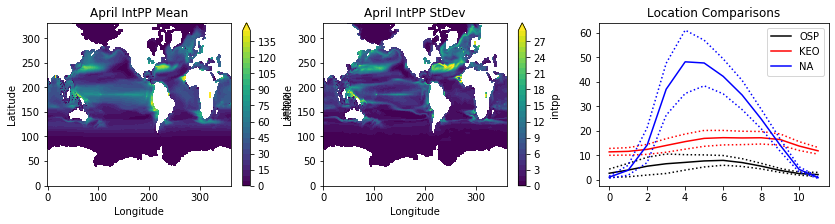

In [14]:
#historical

fig = plt.figure(figsize=(14, 3))

# Irregular levels to illustrate the use of a proportional colorbar
levels = np.arange(0, 150, 5)
levels2 = np.arange(0, 30, 1)

ax = fig.add_subplot(1, 3, 1)
(clim_m_hist.intpp*(10**8)).isel(month=4).plot(levels=levels)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('April IntPP Mean')

ax = fig.add_subplot(1, 3, 2)
(clim_std_hist.intpp*(10**8)).isel(month=4).plot(levels=levels2)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('April IntPP StDev')

ax = fig.add_subplot(1, 3, 3)
var = clim_m_hist.intpp.isel(x=150,y=250,member_id=0)*10**8
var2 = clim_m_hist.intpp.isel(x=90,y=225,member_id=0)*10**8
var3 = clim_m_hist.intpp.isel(x=250,y=275,member_id=0)*10**8
var_st = clim_std_hist.intpp.isel(x=150,y=250,member_id=0)*10**8
var2_st = clim_std_hist.intpp.isel(x=90,y=225,member_id=0)*10**8
var3_st = clim_std_hist.intpp.isel(x=250,y=275,member_id=0)*10**8

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.plot(var,'k',label='OSP')
plt.plot(var+var_st,':k')
plt.plot(var-var_st,':k')
plt.plot(var2,'r',label='KEO')
plt.plot(var2+var2_st,':r')
plt.plot(var2-var2_st,':r')
plt.plot(var3,'b',label='NA')
plt.plot(var3+var3_st,':b')
plt.plot(var3-var3_st,':b')
plt.legend()
plt.title('Location Comparisons')

# SSP585 Decadal Climatologies

In [128]:
clim_m_hist.intpp.y

clim_m_85 = ds_85.groupby('time.month').mean('time')
clim_std_85 = ds_85.groupby('time.month').std('time')

<xarray.DataArray 'y' (y: 332)>
array([  0,   1,   2, ..., 329, 330, 331])
Dimensions without coordinates: y

In [ ]:
AFTER LUNCH: 
    GO BACK AND LOOK FOR CESM INSTEAD OF IPSL
    SET TIME THING TO TRUE NOT FALSE SO I CAN SELECT PERIODS DECADAL CLIMATOLOGIES